# Finding Activity Cliffs with RDKit
This notebook demonstrates the methods of the class `MorganSimilarity` stored in `utils/similarity_sali.py`

## Version X
- version in work

## Author
- Oskar Hoff
- oskar.hoff@gmail.com
- Affiliation: University of Graz
- Background in synthetic and medicinal chemistry


# Background


## Drug Discovery - Oncology
- Overall cost to bring a new anticancer drug to the market ranges from **$944 million** to **$4.54 billion** (2019 USD) - M. Schlander et *al.*: *PharmacoEconomics* 39, 1243–1269 (**2021**)
- The promise of virtual screening is to make the drug discovery funnel more efficient:

![drug discovery funnel](images/Funnel.png)

(Source: https://multispaninc.com/drug-discovery-services-and-high-throughput-screening)


## The Target - BRD4
Bromodomain-containing protein 4 (BRD4) is a significant target due to its role in regulating gene expression and its involvement in cancer and other diseases.

**1. Role and Function:**

BRD4 is a member of the bromodomain and extra-terminal (BET) family of proteins, which play a crucial role in regulating gene expression.
It specifically recognizes and binds acetylated lysines on histones, a process critical for the regulation of transcriptional machinery.
By interacting with acetylated histones, BRD4 can recruit other transcriptional coactivators and chromatin-modifying enzymes, thereby influencing gene expression patterns.

**2. Biological Significance:**

**Cancer:** BRD4 has been implicated in several cancers, including leukemia, lymphoma, and solid tumors. It contributes to the regulation of oncogenes such as MYC and is involved in the formation of super-enhancer regions, which drive the expression of oncogenes.
**Inflammatory Diseases:** Beyond cancer, BRD4 is also associated with inflammatory conditions and has been explored as a target for treating diseases like rheumatoid arthritis.

**3. Drug Discovery:**

**Inhibitors:** Targeting BRD4 with small molecules, known as BET inhibitors, has shown promise in preclinical studies and clinical trials. These inhibitors can disrupt BRD4's interaction with acetylated lysines, thereby modulating gene expression.
**Degradation:** BRD4 is a common target in the field of targeted-protein degradation (molecular glues and PROTACs). Which are outside the scope of this project. 

**References:**

- Filippakopoulos, P., et al. (2012) "Selective inhibition of BET bromodomains." Nature, 468(7327), 1067-1073. DOI: 10.1038/nature09504
- Zhang, J., et al. (2017) "Structural basis for the inhibition of the BET bromodomain by small molecules." Journal of Medicinal Chemistry, 60(12), 5600-5611. DOI: 10.1021/acs.jmedchem.6b01630
- Wu, L., et al. (2019) "Development of potent and selective inhibitors targeting the BRD4 bromodomain." Nature Communications, 10, 2511. DOI: 10.1038/s41467-019-10544-0


# Methods
## Morgan Fingerprints 

- The python package RDKit can interpret chemical structures (atoms, bonds, charges, valences, etc.)
- For mathematical operations fingerprints are often used to approximate the structural features of small, organic molecules.
- Function used: `rdkit.Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect` 
    - generates a list of bitvector objects
    - can be converted to NumPy arrays and pandas DataFrames
- Main properties of Morgan fingerprints:
    - Important tuneable parameters:
        - `nBits`: Length of the bitvector has to be chosen by the user
        - `radius`: Size of atom environment considered. 
    - Generation is deterministic
## Distance Metrics
Distance metrics
Originally, I attempted to calculate pairwise Tanimoto scores using `rdkit.DataStructs.TanimotoSimilarity` (code not shown). This approach was abandoned as it required to calculate the full distance matrix and was too computationally expensive. 

**Tanimoto Similarity Index**

The manner in which the function `rdkit.DataStructs.TanimotoSimilarity` calculates the Tanimoto score for explicit bit vectors can be interpreted as the fraction of the intersection divided by the union:

$$ T(A, B) = \frac{|A \cup B|}{|A \cap B|} $$
(https://www.rdkit.org/docs/source/rdkit.DataStructs.cDataStructs.html)

**Euclidean distance**

As we are searching for activity cliffs, we are especially interested in the distance of very similar molecules. Therefore, `sklearn.neighbors.NearestNeighbors` was utilized. By default Euclidean distance `(metric='minkowski')` is used: 


$$ d(A, B) = \sqrt{\sum_{i=1}^{n} (A_i - B_i)^2} $$
(https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)


**Jaccard Dissimilarity Index**

`sklearn.neighbors.NearestNeighbors(metric='jaccard')` relies on `scipy.spatial.distance.jaccard` and can be interpreted as the fraction of the union divided by the intersection allowing the conversion to the respective Tanimoto score: 
$$ J(A, B) = \frac{|A \cap B|}{|A \cup B|} = 1 - T(A, B)$$
(https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.jaccard.html#scipy.spatial.distance.jaccard)

## Distance Metric Summary

| Metric | identical molecules | completely different molecules| comment |
| ------ | --------------------| ----------------------------- | ------- |
| Tanimoto | 1 | 0 | common metric in chemical data science |
| Euclidean distance | 0 | $ \infty $ | fastest approach found |
| Jaccard | 0 | 1 | Jaccard = 1 - Tanimoto |

## SALI


The Structure-Activity Landscape Index (SALI) is calculated by the fraction of the absolute difference in pIC50 values between two molecules divided by the Jaccard Dissimilarity of the respective molecules. 

$$ \text{SALI(A,B)} = \frac{|\text{pIC50(A)} - \text{pIC50(B)}|}{\text{J(A,B)}} $$


## Activity Cliffs

SALI is specific to any given pair of molecules within a data set. SALI is high for very similar molecules (low $J(A,B)$) with very different activities (large $|Δ(pIC50)|$), such a scenario is considered an `activity cliff` and can be very insightful to understand structure-activity realationships (SAR). The SARI threshold has to be determined for each data set individually. To identify activity cliffs systematically, a threshold is defined: 

$$ \mathrm{SALI}(A,B) > \overline{\mathrm{SALI}} + d \cdot \sigma_{\mathrm{SALI}} $$

where:
- $ \overline{\mathrm{SALI}} $ is the mean SALI value of the data set
- $ \sigma_{\mathrm{SALI}} $ is the standard deviate of SALI values
- $ d $ is an adjustable parameter

# Setup Code
## Environment

In [1]:
### use conda environment cadd

### main packages:

##  python 3.11.11

##  conda-forge
# pandas 2.2.3
# rdkit 2024.09.4
# sklearn 1.6.1

import sys

print(sys.executable)

/home/oskar/anaconda3/envs/cadd/bin/python


## Imports & Jupyter Settings

In [2]:
### RDLogger
from rdkit import RDLogger

# Suppress RDKit logs
RDLogger.DisableLog("rdApp.*")

# Re-enable logging if needed
# RDLogger.EnableLog('rdApp.*')

In [3]:
### Standard imports
import pandas as pd
import numpy as np
import pickle
import copy
import os

In [4]:
### NumPy arrays - floats
np.set_printoptions(
    precision=2,  # round values
    suppress=True,
)  # avoid scientific notation

### pandas DataFrames
pd.set_option("display.float_format", "{:.3f}".format)  # Round to 2 decimal places

In [5]:
### To track progress of slow code
# from tqdm.auto import tqdm
from tqdm import tqdm

tqdm.pandas()  # Initialize tqdm for pandas

In [ ]:
### Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
### Standard Cheminformatics imports
from rdkit import Chem
from rdkit.Chem import PandasTools

## Functions
**render_mol()**

`rdkit.PandasTools.ChangeMoleculeRendering(df)` renders mol objects in a pandas DataFrames in Jupyter notebooks if the output is html text:

![html](images/render_html.png)

Output as plain text shows the mol objects id:

![plain](images/render_plain.png)



In [ ]:
def render_mol(df):
    '''
    Renders the "Mol" column of a DataFrame for visual inspection of chemical structures. 
    '''
    PandasTools.ChangeMoleculeRendering(df)
    return df

## Utils
To ease reusability a class `MorganSimilarity` was generated and stored in `utils/similarity_sali.py`

In [9]:
from utils.similarity_sali import MorganSimilarity
from utils import pd_mol

# Data
The data set for this project was downloaded from [ChEMBL](https://www.ebi.ac.uk/chembl/) as csv file and pre-processed using the chemical data science tool [DataWarrior](https://openmolecules.org/datawarrior/):
## Pre-Processing
- BRD4 inhibitors from `ChEMBL`
- Preprocessing (not shown) involved:
    - target ID `O60885` (UniProtID for BRD4)
        - --> **3.8 k** data points
    - filter for `bioactivity: IC50` and `unit: nM`
    - ChEMBL_ID duplicates removed (keeps lowest IC50)
    - access chemical structures as `SMILES`
    - generate standardized RDKit `mol objects`
        - generate `standardized SMILES`
    - removed structural duplicates
    - Apply molecular weight filters:
        - `> 250 g/mol` - fragments
        - `< 600 g/mol` - mostly heterobifunctional binders (PROTACs)
        - --> **2.6 k** data points
- API access to `ChEMBL` was out of the scope for this project, but is on my to do list (`import chembl_webresource_client`)


## Load Data
`00_brd4_inhibitors_3k.csv` contains 2684 unique molecules. They are described by (columns):
- `ID`: string - unique identifier from `ChEMBL`
- `IC50_nM`: float - half maximal inhibitory concentration in `nmol / L`. Simply put, the lower this number the higher the potency of this compound is. 
- `Smiles`: sting - chemical structure

In [10]:
### Data from csv
df = pd.read_csv('data/00_brd4_inhibitors_3k.csv')
df.set_index('ID', inplace=True)

### The binary activity label is not necessary for this analysis
df.drop(columns=['active'], inplace=True) 

### Show DataFrame
print(len(df))
df

2684


,IC50_nM,Smiles
ID,,
CHEMBL5171062,0.330,CCS(=O)(=O)Cc1ccc(Oc2ccc(F)cc2F)c(-c2cn(C)c(=O...
CHEMBL5171510,0.390,Cc1cc(-c2cc3c(=O)n(C)cc(-c4cc(NS(C)(=O)=O)ccc4...
CHEMBL5209870,0.400,COc1cc(OC)c2c(=O)[nH]c(-c3cc(C)c(OCCOc4ccccc4C...
CHEMBL5091333,0.400,[2H]C([2H])([2H])c1nnn(C)c1-c1cc2c(cc1F)c1ncc(...
CHEMBL4077038,0.430,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OCCC...
...,...,...
CHEMBL4740073,2670000.000,CCN(CC)S(=O)(=O)c1ccc(C2CC(=O)N(C)C2)c(-c2csc3...
CHEMBL4757257,3200000.000,CCN(CC)S(=O)(=O)c1ccc(C2CC(=O)N(C)C2)c(-c2cccc...
CHEMBL4753273,4500000.000,CCN(CC)S(=O)(=O)c1ccc(C2CC(=O)N(C)C2)c(CCc2ccc...


## pIC50

In medicinal chemistry the activity of an inhibitor is often reported as IC50 (Half maximal inhibitory concentration). When comparing IC50 values the *ratio* is more informative than the *difference*. 

Example:
- Inhibitor A: IC50 = `5 µM` 
- Inhibitor B: IC50 = `20 µM` 

--> 'A is 4-fold more active than B.'

Therefore pIC50 values are often used:

$$ \text{pIC50} = -\log_{10}\left(\text{IC50}\right) $$

The histograms of the dataset below demonstrate the usefulness of pIC50 (right) over the original IC50 value (left), as the distribution of the data set can be visualized.  

The most active inhibitor has:
- the lowest IC50 value
- the highest pIC50 value

Functions used:
- `convert_ic50nM_to_pic50`: Convert nM IC50 values to pIC50 according to the formula shown above. 


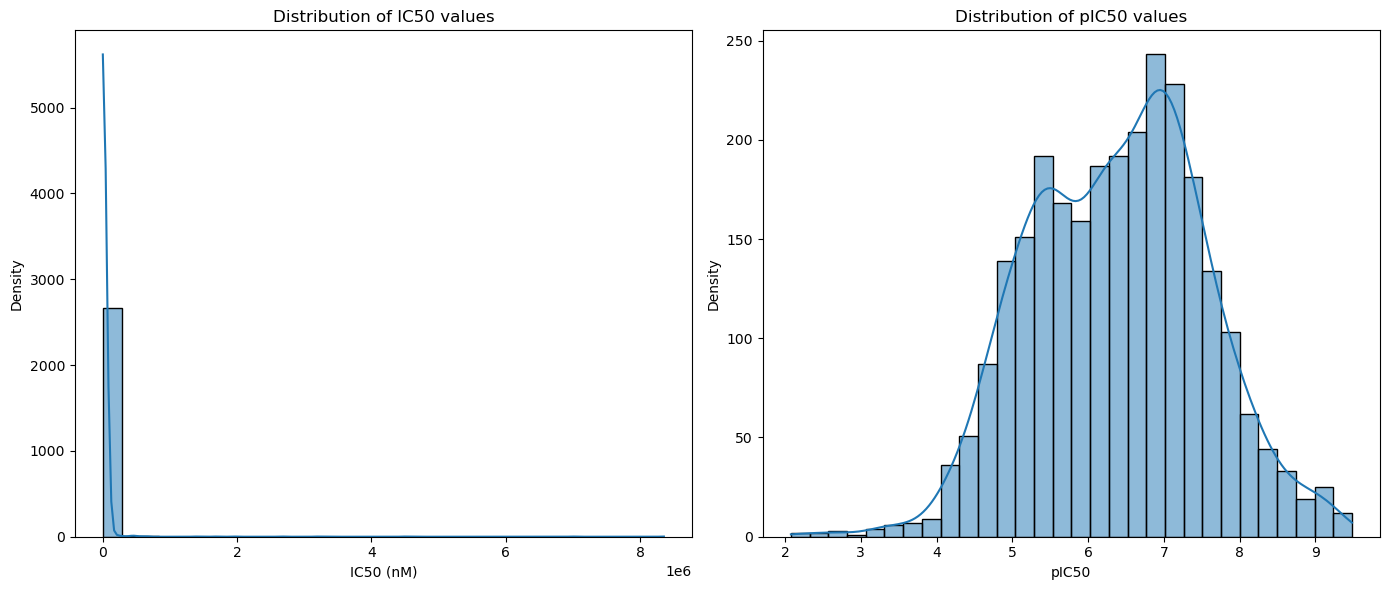

In [11]:
### Calculate pIC50 and chosen cut-offs
df['pIC50'] = df['IC50_nM'].apply(pd_mol.convert_ic50nM_to_pic50)

### Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

### Plot distribution of activity by IC50
sns.histplot(df['IC50_nM'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of IC50 values')
axes[0].set_xlabel('IC50 (nM)')
axes[0].set_ylabel('Density')

### Plot distribution of activity by pIC50
sns.histplot(df['pIC50'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribution of pIC50 values')
axes[1].set_xlabel('pIC50')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

## Mol Column
The python package `RDKit` is built around it's data type `Mol` object, a representation of a chemical molecule. 

Functions used:
- `rdkit.Chem.MolFromSmiles`: Convert a SMILES string to a Mol object.   
- `render_mol`: Render the chemical structures of Mol objects in a pandas DataFrame when output as html text. 
- `pd_mol.standardize_mol_col`: Standardize a pandas.Series of Mol objects ("Mol" column) to ensure reproducibility for molecular structures from different sources. It utilizes multiple subpackages from RDKit.  

,IC50_nM,Smiles,pIC50,Mol
ID,,,,
CHEMBL5171062,0.330,CCS(=O)(=O)Cc1ccc(Oc2ccc(F)cc2F)c(-c2cn(C)c(=O...,9.481,
CHEMBL5171510,0.390,Cc1cc(-c2cc3c(=O)n(C)cc(-c4cc(NS(C)(=O)=O)ccc4...,9.409,

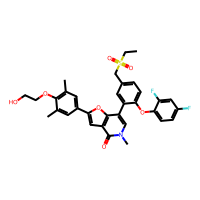
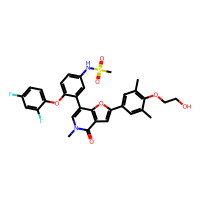

In [12]:
### Generate Mol objects from Smiles strings
df['Mol'] = df['Smiles'].apply(Chem.MolFromSmiles)

### Call render_mol() to visualize the Mol column as chemical structures for inspection
render_mol(df.head(2))

In [13]:
### Standardize the 'Mol' column
df['Mol'] = pd_mol.standardize_mol_col(df['Mol'])

largest_frag=True (rdMolStandardize.FragmentParent):


100%|██████████| 2684/2684 [00:05<00:00, 536.39it/s]


remove_charge=True (rdMolStandardize.Uncharger().uncharge):


100%|██████████| 2684/2684 [00:00<00:00, 14074.60it/s]


tautomerize=False (rdMolStandardize.CanonicalTautomer)
normalize=True (rdMolStandardize.Normalize):


100%|██████████| 2684/2684 [00:03<00:00, 815.63it/s] 


remove_stereo=False (rdMolStandardize.Normalize):
cal_2D_coord_default=True (rdDepictor.Compute2DCoords):


100%|██████████| 2684/2684 [00:01<00:00, 2644.56it/s]


cal_2D_coord_deep=False (rdCoordGen.AddCoords):
cleanup=True (rdMolStandardize.Cleanup):


100%|██████████| 2684/2684 [00:03<00:00, 814.54it/s]


In [14]:
### Columns 'Smiles' and 'IC50_nM' are not required for further analysis
df.drop(columns=['Smiles', 'IC50_nM'], inplace=True)

,pIC50,Mol
ID,,
CHEMBL1232461,7.442,
CHEMBL1233528,5.971,

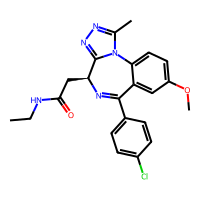
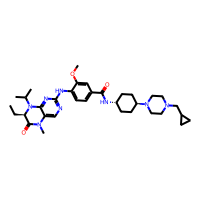

In [15]:
### Sorting the DataFrame by the index
df.sort_index(ascending=True, inplace=True)
render_mol(df.head(2))

## Export DataFrame
This DataFrame is the basis for multiple approaches and is therefore saved as pickled file. 

In [16]:
### Saving the DataFrame to a pickle file
df.to_pickle('temp/01_EDA.pkl')

# MorganSimilarity module
## Morgan Fingerprints 

- `MorganSimilarity.get_morgan_fingerprint()` relies on `rdkit.Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect()` to generate Morgan fingerprints.
- `MorganSimilarity.format_fp()` changes the data type of the Morgan fingerprints:
    - list of bitvectors (default)
    - NumPy array
    - boolean NumPy array
    - pandas DataFrame

In [17]:
### Create a class instance
SALI = MorganSimilarity(df)

### Generate Morgan fingerprints as list of bitvectors
morgan_fp_list = SALI.get_morgan_fingerprint()
print(f'Data type: {type(morgan_fp_list[0])}')

### Convert to DataFrame for inspection
morgan_df = SALI.format_fp('DataFrame')
morgan_df

Data type: <class 'rdkit.DataStructs.cDataStructs.ExplicitBitVect'>


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
ID,,,,,,,,,,,,,,,,,,,,,
CHEMBL1232461,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
CHEMBL1233528,0,1,0,1,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
CHEMBL1287853,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1313432,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1344420,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL5291169,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL848,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
CHEMBL9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Distance Matrix
- The distance matrix of each compound to it's `k-nearest neighbors (KNN)` is calculated with `MorganSimilarity.get_SALI_matrix()` utilizing `sklearn.neighbors.NearestNeighbors`. 
- The parameter `k` allows to calculate only a partial distance metric, assuming that all activity cliffs of interest are within the k-nearest neighbors.
- Choose `k = len(df)` for a the distance matrix.
- As it is likely that molecule A is a neighbor to B when B is a neighbor to A, this method introduces redundancy, especially for larger `k`. 

In [18]:
### Compute the SALI matrix for the nearest neighbor using Euclidean distance (fastest)
_ = SALI.get_SALI_matrix(k=5, dist_metric='minkowski')

### The distance matrix is calculated in the background
SALI.SALI_dict['distance']

/home/oskar/4_KFU_local/programming_1/final_project/utils/similarity_sali.py:182: RuntimeWarning: divide by zero encountered in divide
  SALI_np = delta_pIC50_np / distances_np
/home/oskar/4_KFU_local/programming_1/final_project/utils/similarity_sali.py:182: RuntimeWarning: invalid value encountered in divide
  SALI_np = delta_pIC50_np / distances_np


array([[3.46, 4.12, 4.69, 5.66, 6.08],
       [4.12, 5.1 , 5.48, 5.66, 5.74],
       [4.69, 5.66, 5.92, 7.62, 7.68],
       ...,
       [6.63, 7.07, 7.14, 7.21, 7.21],
       [4.9 , 5.39, 5.39, 5.39, 5.48],
       [3.32, 4.12, 5.83, 6.  , 6.32]], shape=(2684, 5))

The distance matrix can be used to evaluate the parameters for fingerprint generation. The parameters `radius` and `nBits` should be chosen in a way that a minimal amount of compounds have identical fingerprints (or a Euclidean distance of 0). 

In [19]:
radius_list = [2, 3, 10, 20]
nBits_list = [512, 1024, 2048, 4096]
resutls_dict = {}

for radius in tqdm(radius_list):

    results_list = []
    for nBits in nBits_list:
        ### Instantiate the costum class
        SALI = MorganSimilarity(df, radius=radius, nBits=nBits)
        
        ### Generate Morgan fingerprints
        SALI.get_morgan_fingerprint()

        ### Format fingerprints as NumPy array
        SALI.format_fp('np_array')

        ### Compute the SALI matrix for the nearest neighbor using Euclidean distance (fastest)
        SALI.get_SALI_matrix(k=1, dist_metric='minkowski')

        ### Count the number of distances that are 0
        results_list.append(np.sum(SALI.SALI_dict['distance'] == 0))

    resutls_dict[radius] = results_list


  0%|          | 0/4 [00:00<?, ?it/s]/home/oskar/4_KFU_local/programming_1/final_project/utils/similarity_sali.py:182: RuntimeWarning: divide by zero encountered in divide
  SALI_np = delta_pIC50_np / distances_np
/home/oskar/4_KFU_local/programming_1/final_project/utils/similarity_sali.py:182: RuntimeWarning: invalid value encountered in divide
  SALI_np = delta_pIC50_np / distances_np
/home/oskar/4_KFU_local/programming_1/final_project/utils/similarity_sali.py:182: RuntimeWarning: divide by zero encountered in divide
  SALI_np = delta_pIC50_np / distances_np
/home/oskar/4_KFU_local/programming_1/final_project/utils/similarity_sali.py:182: RuntimeWarning: invalid value encountered in divide
  SALI_np = delta_pIC50_np / distances_np
/home/oskar/4_KFU_local/programming_1/final_project/utils/similarity_sali.py:182: RuntimeWarning: divide by zero encountered in divide
  SALI_np = delta_pIC50_np / distances_np
/home/oskar/4_KFU_local/programming_1/final_project/utils/similarity_sali.py:182

In [20]:
### Output
print('columns: radius')
print('index: nBits')
pd.DataFrame(resutls_dict, index=nBits_list)   

columns: radius
index: nBits


,2,3,10,20
512,31,2,2,2
1024,25,2,2,2
2048,23,2,2,2
4096,23,2,2,2


Analysing the DataFrame above:
- `radius` has a stronger effect on differentiability than `nBits`
- even with `radius = 20` one pair of molecules still has identical fingerprints
- this is accepted and 
    - `radius = 3` as well as
    - `nBits = 1024` are chosen as parameters. 

## SALI Matrix
- With the parameters for fingerprint generation selected. The workflow can be started. 
- `k = 10` is selected to set the size of the distance matrix
- `dist_metric = 'jaccard'` must be selected when calculating SALI values
- `stat_summary = True` provide some guidelines how to choose the SALI threshold
- The SALI matrix is a NumPy array of the same shape as the distance matrix. 

In [21]:
### Instantiate the class
SALI_10 = MorganSimilarity(df, radius=3, nBits=1024)

### Generate Morgan fingerprints
SALI_10.get_morgan_fingerprint()

### Format fingerprints as boolean NumPy array
SALI_10.format_fp('boolean_np_array')

### Compute the SALI matrix for the nearest neighbor using Jaccard distance
SALI_10.get_SALI_matrix(k=10, dist_metric='jaccard', stat_summary=True)


2.68e+04 pairs analyzed (including duplicates).
3.60e+06 pairs are possible.
Quantiles (SALI):
0.000    0.000
0.250    0.498
0.500    1.112
0.750    2.113
0.900    3.380
0.990    7.552
0.999   20.272
dtype: float64


/home/oskar/4_KFU_local/programming_1/final_project/utils/similarity_sali.py:182: RuntimeWarning: divide by zero encountered in divide
  SALI_np = delta_pIC50_np / distances_np
/home/oskar/4_KFU_local/programming_1/final_project/utils/similarity_sali.py:182: RuntimeWarning: invalid value encountered in divide
  SALI_np = delta_pIC50_np / distances_np


array([[5.8 , 5.41, 0.08, ..., 0.3 , 0.5 , 3.07],
       [2.84, 4.25, 0.97, ..., 0.78, 0.68, 2.41],
       [1.01, 0.65, 1.64, ..., 2.8 , 2.17, 0.92],
       ...,
       [2.45, 1.2 , 1.27, ..., 0.81, 0.13, 2.32],
       [1.51, 1.2 , 0.07, ..., 0.45, 0.22, 0.86],
       [0.48, 2.36, 3.47, ..., 2.53, 3.07, 3.67]], shape=(2684, 10))

## Pairwise analysis
The SALI distance matrix still only partial and contains duplicates due to the mechanic of the knn approach, but it's distribution (see output from the cell above) can still be used to select a SALI threshold to define activity cliffs: 

The `99.9` percentile with `k = 10` has `SALI = 20`. The histogram below shows that setting the threshold to `20` gives the largest activity cliffs for visual inspection. 

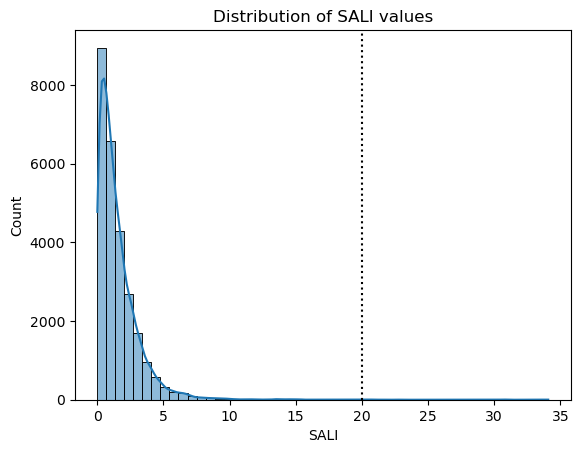

In [22]:
### Set a SALI threshold for inspection
SALI_threshold = 20

### Print the distribution of calculated SALI values
sns.histplot(SALI_10.SALI_dict['SALI'].flatten(), bins=50, kde=True)
plt.title('Distribution of SALI values')
plt.xlabel('SALI')
plt.axvline(x=SALI_threshold, linestyle="dotted", color='black')
plt.show()

,ID_1,pIC50_1,Mol_1,ID_2,pIC50_2,Mol_2,jaccard,ΔpIC50,SALI
0,CHEMBL3819621,5.524,,CHEMBL3819616,5.979,,0.013,0.454,34.086
1,CHEMBL513909,7.602,,CHEMBL4215729,6.187,,0.042,1.415,33.606
2,CHEMBL4085339,5.569,,CHEMBL4077583,5.131,,0.013,0.438,32.840
3,CHEMBL3650969,4.602,,CHEMBL3650937,7.824,,0.105,3.222,30.787
4,CHEMBL4757283,6.854,,CHEMBL4750537,6.234,,0.020,0.620,30.683
5,CHEMBL3650963,4.523,,CHEMBL3650938,7.721,,0.114,3.198,28.075
6,CHEMBL3650964,7.886,,CHEMBL3650963,4.523,,0.125,3.363,26.905
7,CHEMBL3650970,7.602,,CHEMBL3650969,4.602,,0.115,3.000,26.100
8,CHEMBL3650945,7.602,,CHEMBL3650944,5.108,,0.100,2.494,24.942
9,CHEMBL3650882,7.509,,CHEMBL3650881,4.509,,0.132,3.000,22.667

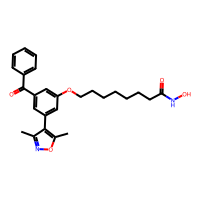
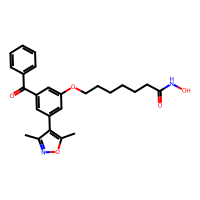
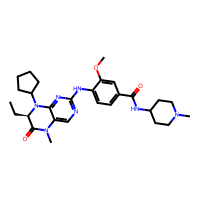
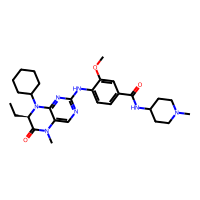
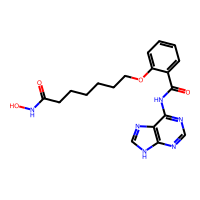
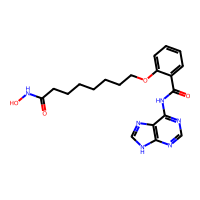
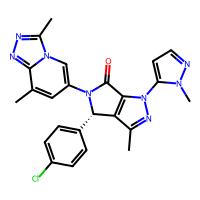
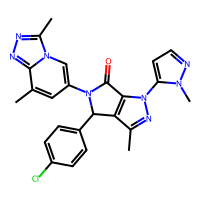
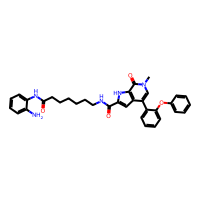
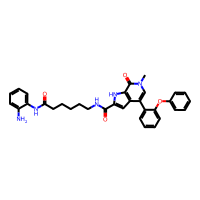
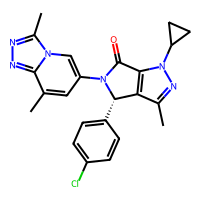
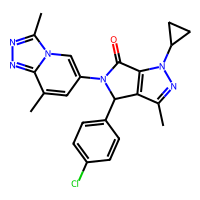
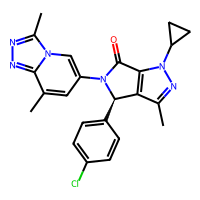
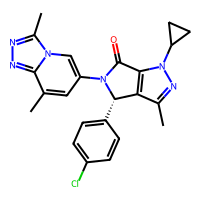
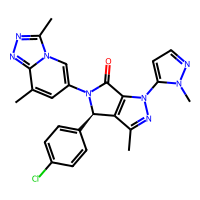
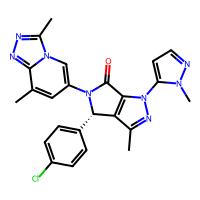
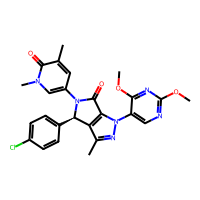
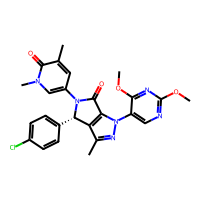
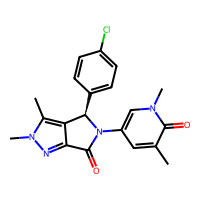
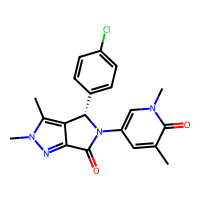
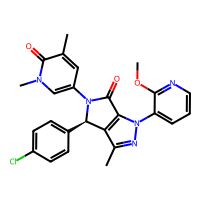
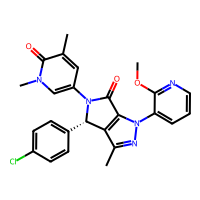
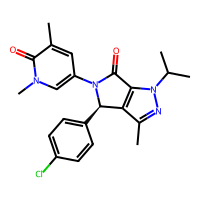
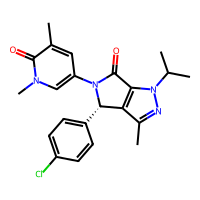
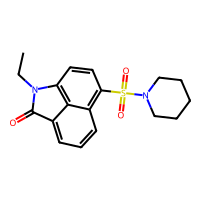
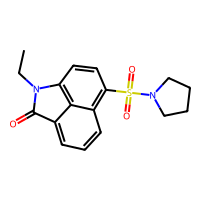
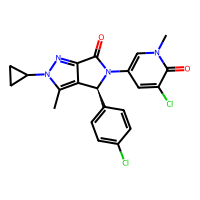
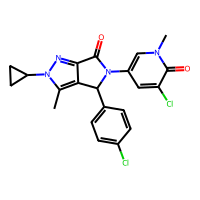

In [23]:
render_mol(SALI_10.get_sali_pairs(SALI_threshold=SALI_threshold))

Analysis of the highest SALI-pairs (above):
- Out of the 14 highest SALI values found, all are due to very small structural differences (chiral center or linker length) and only some have a large jump in activity.
- rows 3, 5 to 11, and 13 share the same substructure and show a clear pattern that the *S*-enantiomer is often 3 orders of magnitues less active than the *R*-enantiomer with the same substitution pattern. 

## "Large" Activity Cliffs
To avoid "small" activity cliffs (high SALI although ΔpIC50 is quite samll), a minimum difference in activity can be chosen. `min_activity_diff = 4` translates to a 10,000-fold difference in activity.  

,ID_1,pIC50_1,Mol_1,ID_2,pIC50_2,Mol_2,jaccard,ΔpIC50,SALI
0,CHEMBL3220211,2.078,,CHEMBL1957266,7.114,,0.264,5.035,19.047
1,CHEMBL3220211,2.078,,CHEMBL2132936,7.456,,0.289,5.378,18.616
2,CHEMBL5181340,7.036,,CHEMBL3220211,2.078,,0.363,4.958,13.672

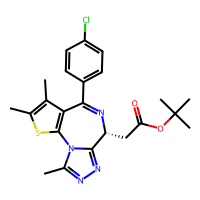
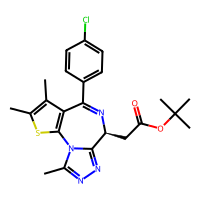
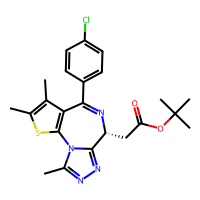
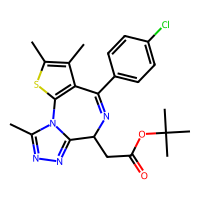
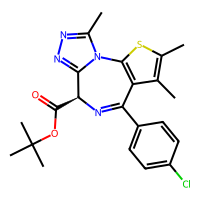
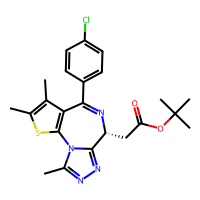

In [ ]:
### Filter for "large" cliffs
SALI_threshold = 7.5
min_activity_diff = 4   # 10_000 fold difference

render_mol(SALI_10.get_sali_pairs(SALI_threshold=SALI_threshold, min_activity_diff=min_activity_diff))

The analysis above shows that the largest jump in activity is observed in the family of *thienotriazolodiazepine*. 
- filtered:
    - `SALI > 7.5`
    - `ΔpIC50 > 4`

## Count Activity Cliffs
The analyses above already revealed two prominent scaffolds of inhibitors for BRD4. However, the methods are quite sensitive to outliers.

/home/oskar/4_KFU_local/programming_1/final_project/utils/similarity_sali.py:178: RuntimeWarning: divide by zero encountered in divide
  ### Compute the absolute differences for each molecule's k-nearest neighbors
/home/oskar/4_KFU_local/programming_1/final_project/utils/similarity_sali.py:178: RuntimeWarning: invalid value encountered in divide
  ### Compute the absolute differences for each molecule's k-nearest neighbors


,pIC50,Mol,CliffCount
ID,,,
CHEMBL5209870,9.398,,58
CHEMBL5091333,9.398,,38
CHEMBL4208405,8.959,,35
CHEMBL4077038,9.367,,35
CHEMBL5084198,9.222,,31
CHEMBL4075567,9.032,,28
CHEMBL5090513,9.222,,27
CHEMBL4846895,9.222,,27
CHEMBL5090808,9.155,,26

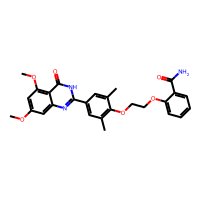
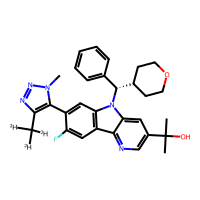
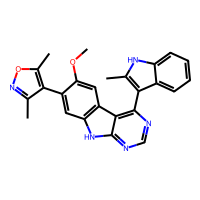
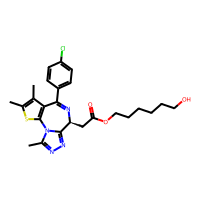
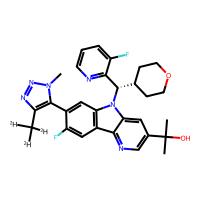
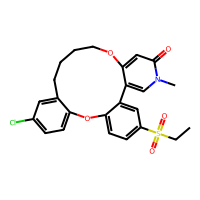
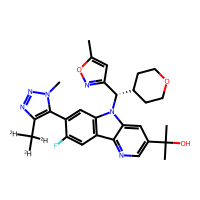
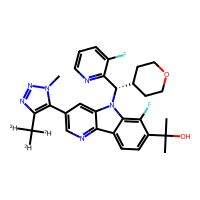
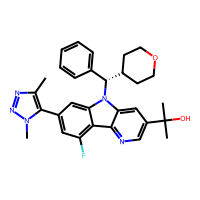
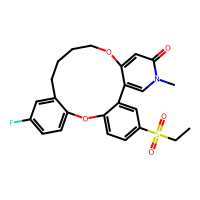

In [56]:
importlib.reload(utils.similarity_sali)
from utils.similarity_sali import MorganSimilarity
### Instantiate the class
SALI_250 = MorganSimilarity(df, radius=3, nBits=1024)

### Generate Morgan fingerprints
SALI_250.get_morgan_fingerprint()

### Format fingerprints as boolean NumPy array
SALI_250.format_fp('boolean_np_array')

### Compute the SALI matrix for the nearest neighbor using Jaccard distance
SALI_250.get_SALI_matrix(k=250, dist_metric='jaccard')

### Use softer constraints for cliff count
SALI_threshold = 5
min_activity_diff = 2   # 100-fold difference
pIC50_threshold = 6     # nano molar inhibitors

### Count the number of cliffs
cliff_count_df = SALI_250.count_cliffs(SALI_threshold=5, min_activity_diff=2)

### Subset for active compounds
render_mol(cliff_count_df.loc[cliff_count_df['pIC50'] > pIC50_threshold].head(10))

In [26]:
import importlib
import utils.similarity_sali